# 오디오 기반 Shot Boundary Detection

Checkpoint path: C:\Users\KHU/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1
Checkpoint path: C:\Users\KHU/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1


PANNs 벡터 추출 중: 100%|██████████| 120/120 [00:00<00:00, 203.14it/s]


[AUTO] Threshold = Mean(0.1582) + 1.00 * Std(0.2065) = 0.3647


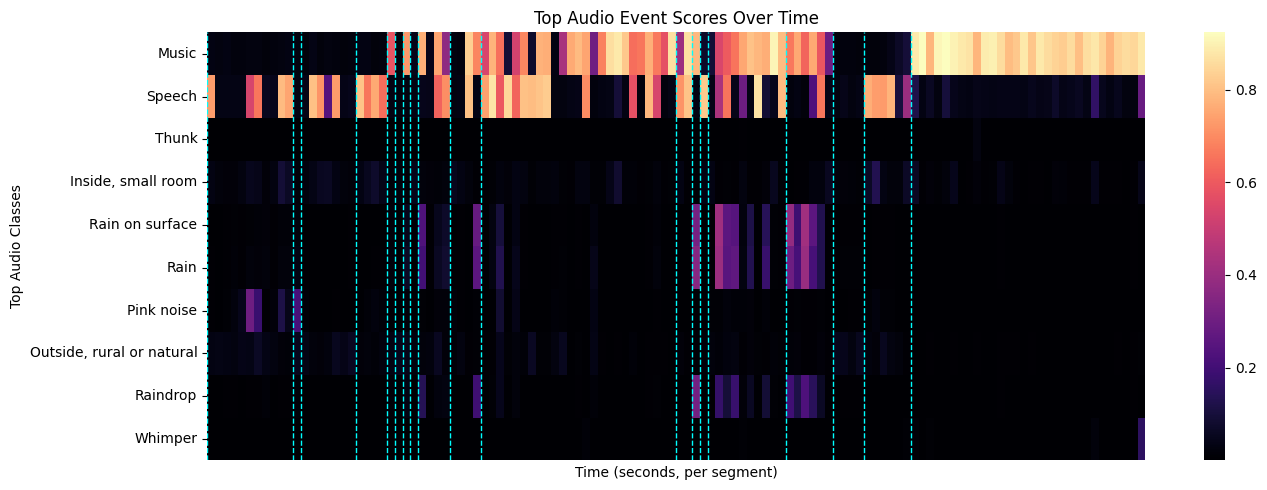

In [8]:
import utils
import cv2

audio, sr = utils.getAudioCroppedFromURL('https://www.youtube.com/watch?v=39O_N9llFno')
topk_indices = utils.get_topk_indices_from_whole_audio(audio, device='cuda', top_k=10)
vectors, segment_sec = utils.extractPANNsVectorsTopK(audio, topk_indices, sr, segment_sec=2.0, device='cuda')
boundaries = utils.detectAudioShotBoundaries(vectors, scale=1)
time_boundaries = [round(b * segment_sec, 2) for b in boundaries]
utils.visualizeAudioVectors(vectors, time_boundaries, topk_indices, segment_sec)


In [9]:
import cv2
import numpy as np
from tqdm import tqdm

def save_with_shot_labels_720p(cap: cv2.VideoCapture, shot_boundaries_sec, output_path="output.mp4", fps=30):
    """
    cap으로부터 전체 영상을 읽고, 초 단위 shot_boundaries_sec에 따라 "SHOT: n" 텍스트를 추가하여 720p로 저장
    """
    orig_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"🎞️ 원본 해상도: {orig_width}x{orig_height}, 총 프레임: {total_frames}")

    if orig_height > 720:
        scale_ratio = 720 / orig_height
        new_width = int(orig_width * scale_ratio)
        new_height = 720
        print(f"⚠️ 해상도가 높아 720p로 리사이즈: {new_width}x{new_height}")
    else:
        new_width = orig_width
        new_height = orig_height
        print(f"✅ 리사이즈 없이 저장: {new_width}x{new_height}")

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))

    # 초 단위 → frame 기준으로 변환
    shot_boundaries_sec = sorted(shot_boundaries_sec)
    current_boundary_idx = 0
    next_boundary_sec = shot_boundaries_sec[current_boundary_idx] if shot_boundaries_sec else float('inf')

    current_shot_idx = 1
    current_shot_text = f"SHOT: {current_shot_idx}"
    current_shot_color = np.random.randint(0, 256, 3).tolist()

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_thickness = 3

    with tqdm(total=total_frames, desc="💾 저장 중", unit="frame") as pbar:
        for frame_idx in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break

            current_time_sec = frame_idx / fps
            if current_time_sec >= next_boundary_sec:
                current_shot_idx += 1
                current_shot_text = f"SHOT: {current_shot_idx}"
                current_shot_color = np.random.randint(0, 256, 3).tolist()
                current_boundary_idx += 1
                next_boundary_sec = (
                    shot_boundaries_sec[current_boundary_idx]
                    if current_boundary_idx < len(shot_boundaries_sec)
                    else float('inf')
                )

            # 텍스트 위치 계산
            (text_width, text_height), baseline = cv2.getTextSize(
                current_shot_text, font, font_scale, font_thickness
            )
            text_x = (orig_width - text_width) // 2
            text_y = text_height + 20

            # 텍스트 추가
            cv2.putText(
                frame,
                current_shot_text,
                (text_x, text_y),
                font,
                font_scale,
                current_shot_color,
                font_thickness,
                cv2.LINE_AA,
            )

            if (orig_width, orig_height) != (new_width, new_height):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)

            out.write(frame)
            pbar.update(1)

    cap.release()
    out.release()
    print(f"✅ 저장 완료: {output_path}")


In [10]:
cap = utils.openVideoStream('https://www.youtube.com/watch?v=39O_N9llFno')
save_with_shot_labels_720p(cap, time_boundaries, output_path="output_shots.mp4", fps=cap.get(cv2.CAP_PROP_FPS))

'https://www.youtube.com/watch?v=39O_N9llFno'에서 30fps 비디오 스트림 URL을 가져오는 중...
🎥 선택된 해상도: 1080p @ 30.0fps
URL: https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1752246265/ei/mdNwaIOxL-CU1d8Pv6eW2QU/ip/163.180.118.139/id/dfd3bf37d965167a/itag/270/source/youtube/requiressl/yes/ratebypass/yes/pfa/1/sgovp/clen%3D21017767%3Bdur%3D240.640%3Bgir%3Dyes%3Bitag%3D137%3Blmt%3D1735967149633253/rqh/1/hls_chunk_host/rr7---sn-n3cgv5qc5oq-bh2z7.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/met/1752224665,/mh/O1/mm/31,26/mn/sn-n3cgv5qc5oq-bh2z7,sn-ogul7nez/ms/au,onr/mv/m/mvi/7/pl/20/rms/au,au/gcr/kr/initcwndbps/4381250/bui/AY1jyLM9Kfe_BYh7Netwbx48jKRK0vG9mtcn5usvCZzUA8mmQMJBE72EsS7EigPtcB4v45boaJtJpYCV/spc/l3OVKYClhduXev-fxfzxeEeB3rM6gbnXh6IEUsCTLLTrC6j7zFJwkQKW_xD7Gk-W/vprv/1/playlist_type/DVR/dover/13/txp/4432434/mt/1752224246/fvip/1/short_key/1/keepalive/yes/fexp/51476175/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,pfa,sgovp,rqh,xpc,gcr,bui,spc,vprv,playlist_type/sig/AJfQdSswRQIh

💾 저장 중: 100%|██████████| 7212/7212 [01:16<00:00, 94.62frame/s] 

✅ 저장 완료: output_shots.mp4


In [11]:
import subprocess

def mux_audio_with_video(video_path: str, audio_path: str, output_path: str):
    """
    무음 영상과 오디오를 합쳐서 하나의 mp4 파일로 저장
    :param video_path: 영상 파일 경로 (예: output.mp4)
    :param audio_path: 오디오 파일 경로 (예: audio.wav)
    :param output_path: 최종 출력 파일 경로 (예: final.mp4)
    """
    command = [
        "ffmpeg", "-y",
        "-i", video_path,
        "-i", audio_path,
        "-c:v", "copy",            # 영상은 다시 인코딩하지 않고 복사
        "-c:a", "aac",             # 오디오는 aac로 인코딩
        "-strict", "experimental",
        "-shortest",               # 영상/오디오 길이 중 짧은 쪽에 맞춤
        output_path
    ]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print(f"✅ 최종 영상 생성 완료: {output_path}")

import soundfile as sf
audio, sr = utils.getAudioCroppedFromURL('https://www.youtube.com/watch?v=39O_N9llFno')
sf.write("audio.wav", audio.squeeze(), sr)

mux_audio_with_video("output_shots.mp4", "audio.wav", "final_with_audio_audio_recognition.mp4")


✅ 최종 영상 생성 완료: final_with_audio_audio_recognition.mp4    
